<a href="https://colab.research.google.com/github/pidipidi/cs470_IAI/blob/main/CNN_assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem 1: Convolution operations using NumPy

### Import necessary libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
import itertools

### Download the MNIST dataset and visualize samples

In [2]:
torch.manual_seed(0)
batch_size = 50
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



You can check what kind of training images are in the MNIST dataset.

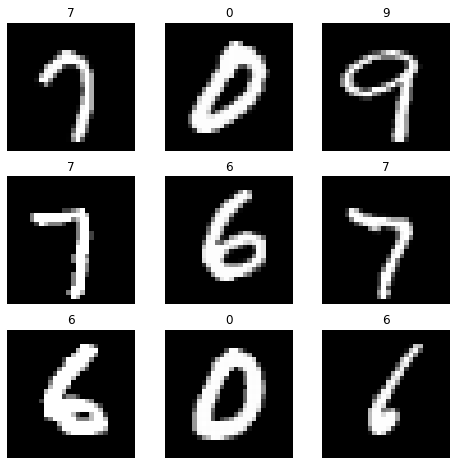

In [3]:
import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(1)

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(label)
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

We then define three filters used in convolution operations:

In [4]:
kernel_1 = [[1,0,0,0,0],
            [0,1,0,0,0],
            [0,0,1,0,0],
            [0,0,0,1,0],
            [0,0,0,0,1]]

kernel_2 = [[0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0],
            [0,0,1,0,0]]

kernel_3 = [[0,0,0,0,1],
            [0,0,0,1,0],
            [0,0,1,0,0],
            [0,1,0,0,0],
            [1,0,0,0,0]]
filters = np.asarray([[kernel_1], [kernel_2], [kernel_3]])

We also define a visualization function for later uses.

In [5]:
def visualize_conv(img_0, img_filtered, img_pooled):
    """
    A 2D Convolution filter

    Parameters
    ---------- 
    img_0: matrix  
      an original image.
    img_filtered: 
      a list of images after applying convolution filters
    img_pooled:
      a list of images after applying convolution filters + max pooling
    """

    figure = plt.figure(figsize=(8, 4))
    figure.add_subplot(2, 4, 1)
    plt.title("Original")
    plt.axis("off")
    plt.imshow(img_0.squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 2)
    plt.title("Filter 1")
    plt.axis("off")
    plt.imshow(img_filtered[0].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 3)
    plt.title("Filter 2")
    plt.axis("off")
    plt.imshow(img_filtered[1].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 4)
    plt.title("Filter 3")
    plt.axis("off")
    plt.imshow(img_filtered[2].squeeze(), cmap="gray")            

    figure.add_subplot(2, 4, 6)
    plt.title("Filter1 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[0].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 7)
    plt.title("Filter 2 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[1].squeeze(), cmap="gray")

    figure.add_subplot(2, 4, 8)
    plt.title("Filter 3 + Pooling")
    plt.axis("off")
    plt.imshow(img_pooled[2].squeeze(), cmap="gray")     

## Convolution + MaxPooling with Numpy 
In this part, we create convolution and pooling functions by only using NumPy.

In [6]:
def convolution(X, filters, stride_size=1, pad_size=0):
    """
    Applies a 2D convolution over an input signal

    Parameters
    ---------- 
    X: Numpy Array
      an input data of shape (c, h, w), where h and w is the height and width
      of the input image. Note that we use black-white images so the number of 
      channel c is 1.
  
    Returns
    ---------- 
    out:     
      an output data given X.
    """
    c, h, w = X.shape
    n_f, _, filter_h, filter_w = filters.shape

    out_h = (h + 2 * pad_size - filter_h) // stride_size + 1
    out_w = (w + 2 * pad_size - filter_w) // stride_size + 1

    # add padding to height and width.
    in_X = np.pad(X, [(0, 0), (pad_size, pad_size), (pad_size, pad_size)], 'constant')
    out  = np.zeros((n_f, out_h, out_w))

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Apply the convolution filters
    for k in range(n_f):
      for j in range(out_h):
        for i in range(out_w):
          vert_start = j * stride_size
          vert_end = j * stride_size + filter_h
          horiz_start = i * stride_size
          horiz_end = i * stride_size + filter_w
          X_sub = X[0, vert_start:vert_end, horiz_start:horiz_end]
          out[k,j,i] = float(np.sum(np.multiply(X_sub, filters[k])))

        
    # END OF YOUR CODE                                                          #
    #############################################################################
    return out

def max_pooling(X, pool_size=2, stride_size=2):
    """
    Applies a 2D max pooling over an input signal

    Parameters
    ---------- 
    X: Numpy Array  
      an input data of shape (c, h, w), where c, h, and w are the number of 
      channels, the height, and the width of the input image. 
  
    Returns
    ---------- 
    pool_out:     
      an output data given X.
    """
    c, h, w = X.shape

    #Preparing the output of the pooling operation.
    pool_out = np.zeros((c, 
                         np.uint16((h-pool_size)/stride_size)+1,
                         np.uint16((w-pool_size)/stride_size)+1,
                         ))
    
    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    #############################################################################     
    # Apply max pooling
    for k in range(c):
      for i in range(np.uint16((h-pool_size)/stride_size)+1):
        for j in range(np.uint16((w-pool_size)/stride_size)+1):
            pool_segment = X[k, i * stride_size: i * stride_size + pool_size, j * stride_size: j * stride_size + pool_size]
            pool_out[k, i, j] = np.max(pool_segment)

    # END OF YOUR CODE                                                          #
    #############################################################################            
    return pool_out    

Visualize the filtering and pooling results for comparison.

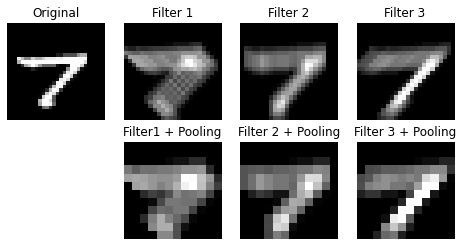

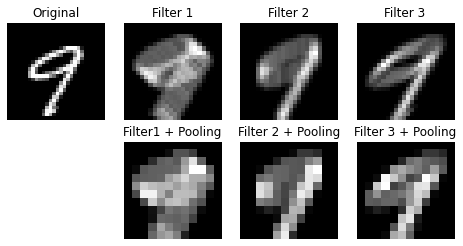

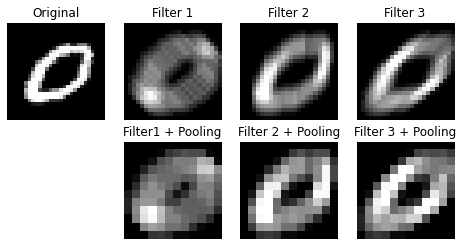

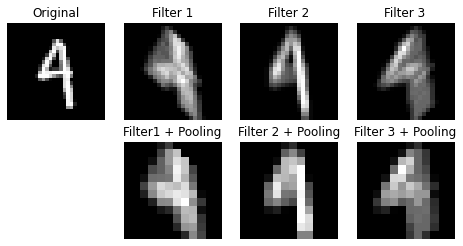

In [7]:
# fix the random seed
torch.manual_seed(6)
numpy_return = []

# visualize a random 5
for i in range(1, 5):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]

    out1 = convolution(img.numpy(), filters, stride_size=1, pad_size=0)
    out2 = max_pooling(out1)

    visualize_conv(img, out1, out2)
    numpy_return.append([out1.copy(), out2.copy()]) # save the result
            

## Convolution + MaxPooling with PyTorch 
In this part, we create convolution and pooling functions by using PyTorch.

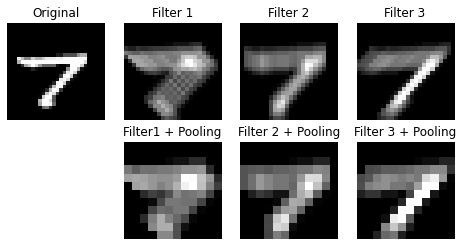

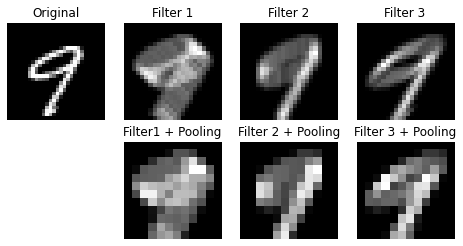

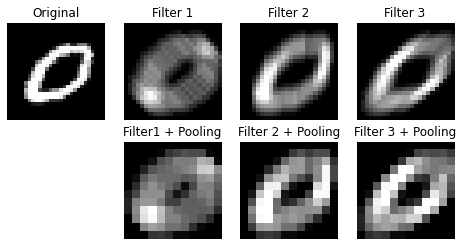

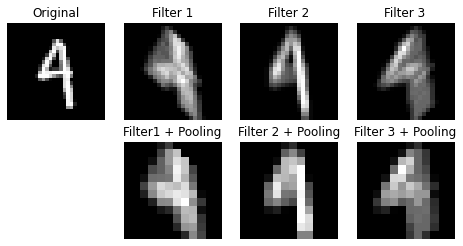

In [8]:

class CNN1(nn.Module):
  """
  A simple convolutional neural network (CNN):
    input - convolution - output
  """  
  def __init__(self):
    """initialize layers"""
    super(CNN1, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Define a CNN layer with a single channel, 3 filters, and 5 kernel size.
    # You should diable using the bias.

    self.conv = nn.Conv2d(1, 3, 5, bias=False)

    # END OF YOUR CODE                                                          #
    ############################################################################# 

    # Force to set the internal weight using the pre-defined kernels. 
    with torch.no_grad():
        self.conv.weight.data[0][0] = torch.tensor(kernel_1)
        self.conv.weight.data[1][0] = torch.tensor(kernel_2)
        self.conv.weight.data[2][0] = torch.tensor(kernel_3)        
        #self.conv.bias.data.zero_()

  def forward(self, x):
    """forward pass"""
    out = self.conv(x)
    return out

class CNN2(nn.Module):
  """
  A simple convolutional neural network (CNN):
    input - convolution - max pooling - output
  """    
  def __init__(self):
    """initialize layers"""
    super(CNN2, self).__init__()

    #############################################################################
    # PLACE YOUR CODE HERE                                                      #
    ############################################################################# 
    # Define a CNN layer with a single channel, 3 filters, and 5 kernel size.
    # Connect a max pooling with 2 kernel size. 
    # You should diable using the bias.
    self.conv = nn.Conv2d(1, 3, 5, bias=False)
    self.pool = nn.MaxPool2d(2, 2)


    # END OF YOUR CODE                                                          #
    ############################################################################# 

    # Force to set the internal weight using the pre-defined kernels. 
    with torch.no_grad():
        self.conv.weight.data[0][0] = torch.tensor(kernel_1)
        self.conv.weight.data[1][0] = torch.tensor(kernel_2)
        self.conv.weight.data[2][0] = torch.tensor(kernel_3)
        #self.conv.bias.data.zero_()

  def forward(self, x):
    """forward pass"""
    out = self.conv(x)
    out = self.pool(out)
    return out


filter_net         = CNN1()
filter_pooling_net = CNN2()

torch.manual_seed(6)
pytorch_return = []
for i in range(1, 5):
    sample_idx = torch.randint(len(train_loader.dataset), size=(1,)).item()
    img, label = train_loader.dataset[sample_idx]
    x = img.unsqueeze(0)

    out1 = filter_net(x).detach().numpy()[0]
    out2 = filter_pooling_net(x).detach().numpy()[0]
 
    visualize_conv(x, out1, out2)
    pytorch_return.append([out1.copy(), out2.copy()])

To analyze two types of results, you can also compare the stored results, too. 